![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)







### Copyright notice

> <p><small><small>Copyright 2025 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Locomotion in The Playground! <a href="https://colab.research.google.com/github/google-deepmind/mujoco_playground/blob/main/learning/notebooks/locomotion.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a>

In this notebook, we'll walk through a few locomotion environments available in MuJoCo Playground.

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".


In [1]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

In [2]:
#@title Import The Playground

from mujoco_playground import wrapper
from mujoco_playground import registry

# Locomotion

MuJoCo Playground contains a host of quadrupedal and bipedal environments (all listed below after running the command).

In [3]:
registry.locomotion.ALL

['BarkourJoystick',
 'BerkeleyHumanoidJoystickFlatTerrain',
 'BerkeleyHumanoidJoystickRoughTerrain',
 'G1JoystickFlatTerrain',
 'G1JoystickRoughTerrain',
 'Go1JoystickFlatTerrain',
 'Go1JoystickRoughTerrain',
 'Go1Getup',
 'Go1Handstand',
 'Go1Footstand',
 'H1InplaceGaitTracking',
 'H1JoystickGaitTracking',
 'Op3Joystick',
 'SpotFlatTerrainJoystick',
 'SpotGetup',
 'SpotJoystickGaitTracking',
 'DigitRefTracking_Loco_JaxPPO']

In [4]:
env_name = 'DigitRefTracking_Loco_JaxPPO'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)

xml_path /home/fliu305/mujoco_playground/mujoco_playground/_src/locomotion/digit_v3/xmls/scene_mjx_feetonly.xml
assets /home/fliu305/mujoco_playground/mujoco_playground/_src/locomotion/digit_v3/xmls


In [5]:
env_cfg

action_repeat: 1
action_scale: 1
ctrl_dt: 0.005
early_termination: true
episode_length: 1800
history_len: 1
obs_noise:
  level: 0
  scales:
    gravity: 0.05
    gyro: 0.2
    joint_pos: 0.01
    joint_vel: 1.5
reward_config:
  scales:
    action_rate: -0.01
    projected_gravity_penalty: -2.0
    root_motion_penalty: -1.0
    tracking_endeffector_pos: 1.5
    tracking_joint_pos: 3.0
    tracking_root_ori: 2.0
    tracking_root_pos: 2.0
    tracking_root_vel: 1.5
  tracking_sigma: 0.5
sim_dt: 0.001

## Joystick

Let's train the joystick policy and visualize rollouts:

In [6]:
from mujoco_playground.config import locomotion_params
ppo_params = locomotion_params.brax_ppo_config(env_name)
ppo_params

action_repeat: 1
batch_size: 128
discounting: 0.97
entropy_cost: 0.01
episode_length: 1800
learning_rate: 5.0e-05
max_grad_norm: 1.0
network_factory:
  policy_hidden_layer_sizes: !!python/tuple
  - 512
  - 512
  - 256
  - 256
  policy_obs_key: state
  value_hidden_layer_sizes: !!python/tuple
  - 512
  - 512
  - 512
  - 256
  - 256
  value_obs_key: state
normalize_observations: true
num_envs: 4096
num_evals: 10
num_minibatches: 32
num_timesteps: 300000000
num_updates_per_batch: 4
reward_scaling: 1.0
unroll_length: 20

Domain randomization was used to make the policy robust to sim-to-real transfer. Certain environments in the Playground have domain randomization functions implemented. They're available in the registry and can be passed directly to brax RL algorithms. The [domain randomization](https://github.com/google-deepmind/mujoco_playground/blob/main/mujoco_playground/_src/locomotion/go1/randomize.py) function randomizes over friction, armature, center of mass of the torso, and link masses, amongst other simulation parameters.

In [7]:
registry.get_domain_randomizer(env_name)

Env 'DigitRefTracking_Loco_JaxPPO' does not have a domain randomizer in the locomotion registry.


In [8]:
#@title Training fn definition
import json
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]

ckpt_path = epath.Path("checkpoints").resolve() / env_name
ckpt_path.mkdir(parents=True, exist_ok=True)
print(f"{ckpt_path}")

with open(ckpt_path / "config.json", "w") as fp:
  json.dump(env_cfg.to_json(), fp, indent=4)


def policy_params_fn(current_step, make_policy, params):
  del make_policy  # Unused.
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = ckpt_path / f"{current_step}"
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"]])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

randomizer = registry.get_domain_randomizer(env_name)
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress,
    policy_params_fn=policy_params_fn,
)

/home/fliu305/mujoco_playground/learning/notebooks/checkpoints/DigitRefTracking_Loco_JaxPPO
Env 'DigitRefTracking_Loco_JaxPPO' does not have a domain randomizer in the locomotion registry.


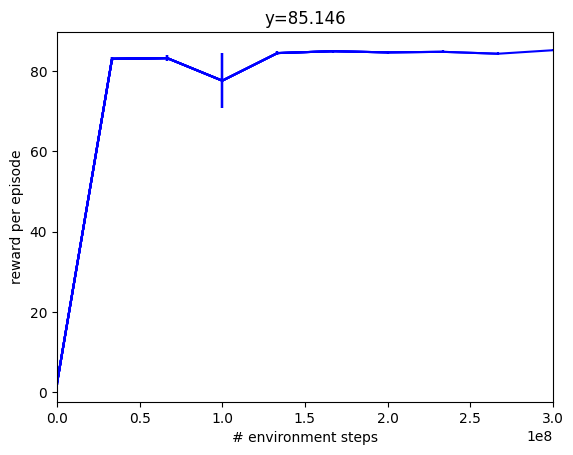

time to jit: 0:01:12.783149
time to train: 1:31:03.702438


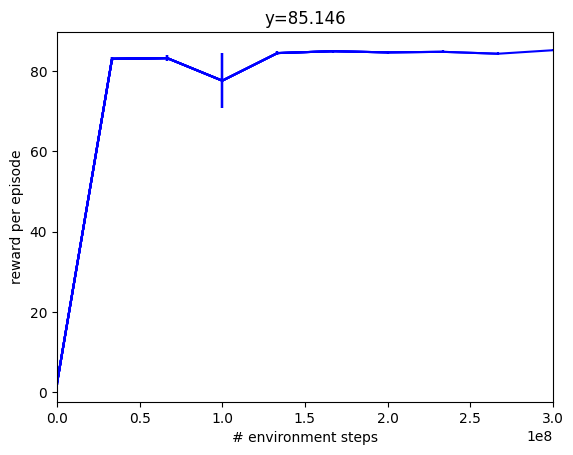

In [9]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    num_timesteps=3e8,
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [10]:
#@title Rollout and Render
from mujoco_playground._src.gait import draw_joystick_command

env = registry.load(env_name)
eval_env = registry.load(env_name)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

rng = jax.random.PRNGKey(1)

rollout = []
modify_scene_fns = []

x_vel = 0.3  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
yaw_vel = 0.0  #@param {type: "number"}
command = jp.array([x_vel, y_vel, yaw_vel])

phase_dt = 2 * jp.pi * eval_env.dt * 1.5
phase = jp.array([0, jp.pi])

for j in range(1):
  print(f"episode {j}")
  state = jit_reset(rng)
  state.info["phase_dt"] = phase_dt
  state.info["phase"] = phase
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    if state.done:
      break
    state.info["command"] = command
    rollout.append(state)

    # xyz = np.array(state.data.xpos[eval_env.mj_model.body("torso").id])
    # xyz += np.array([0, 0.0, 0])
    # x_axis = state.data.xmat[eval_env._torso_body_id, 0]
    # yaw = -np.arctan2(x_axis[1], x_axis[0])
    # modify_scene_fns.append(
    #     functools.partial(
    #         draw_joystick_command,
    #         cmd=state.info["command"],
    #         xyz=xyz,
    #         theta=yaw,
    #         scl=np.linalg.norm(state.info["command"]),
    #     )
    # )

render_every = 1
fps = 1.0 / eval_env.dt / render_every
print(f"fps: {fps}")
traj = rollout[::render_every]
# mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640*2,
    height=480,
    # modify_scene_fns=mod_fns,
)
media.show_video(frames, fps=fps, loop=False)

xml_path /home/fliu305/mujoco_playground/mujoco_playground/_src/locomotion/digit_v3/xmls/scene_mjx_feetonly.xml
assets /home/fliu305/mujoco_playground/mujoco_playground/_src/locomotion/digit_v3/xmls
xml_path /home/fliu305/mujoco_playground/mujoco_playground/_src/locomotion/digit_v3/xmls/scene_mjx_feetonly.xml
assets /home/fliu305/mujoco_playground/mujoco_playground/_src/locomotion/digit_v3/xmls
episode 0
fps: 200.0


100%|██████████| 1800/1800 [00:02<00:00, 624.88it/s]


🙌 Hasta la vista!